### Predicting House Prices

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import psycopg2
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host
                                                            ,postgres_port,postgres_db))
house_prices = pd.read_sql_query('select * from houseprices', con = engine)
engine.dispose()

In [4]:
house_prices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [30]:
house_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

from the information in the above it looks like there are many null values in a number of variable.But it is hard to tell whether they are real null(missing values) or they have information to convey.like for instance varianbles such as alley,fence have None values but those None values are logically meaning the housing does not poses fence or allley.Therefore we will require great causion in dealing with the missing value if there are at all.

to understand our target variable which is 'sales price', lets check its distribution using histogram.

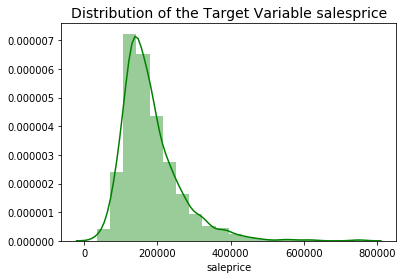

In [16]:
sns.distplot(house_prices['saleprice'], hist = True, kde = True, bins = 20, color = 'g');
plt.title('Distribution of the Target Variable salesprice', fontsize = 14);

we can see that it is skewed little to the right.Visually we can say that our target variable is not normally distributed.

Moving forward to be able to select the features that mostly affect our target variable,it is good to run and see the relationship either through correlation matrix or through visualizing it using seaborn's pairplot.plotting 79 variables might be a hectic because we have to divide the features and see their interaction as our canvas will not be big enough for our eyes to visualized properly all the plots at once.So my preference was correlation matrix. So lets start with the numerical variables first.

In [21]:
relationships = house_prices.corr()
relationships

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
lotarea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
bsmtfinsf1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [52]:
corr_matrix = relationships[relationships['saleprice'] > 0.6][relationships[relationships['saleprice'] > 0.6].index]
corr_matrix

,overallqual,totalbsmtsf,firstflrsf,grlivarea,garagecars,garagearea,saleprice
overallqual,1.000000,0.537808,0.476224,0.593007,0.600671,0.562022,0.790982
totalbsmtsf,0.537808,1.000000,0.819530,0.454868,0.434585,0.486665,0.613581
firstflrsf,0.476224,0.819530,1.000000,0.566024,0.439317,0.489782,0.605852
grlivarea,0.593007,0.454868,0.566024,1.000000,0.467247,0.468997,0.708624
garagecars,0.600671,0.434585,0.439317,0.467247,1.000000,0.882475,0.640409
garagearea,0.562022,0.486665,0.489782,0.468997,0.882475,1.000000,0.623431
saleprice,0.790982,0.613581,0.605852,0.708624,0.640409,0.623431,1.000000


From the above correlation matrix the features with a strong relationship with target variable(saleprice) and with a correlation value of greater than 0.5 wth the target variable are,the above 7 features as we can see from the above table.The next step is adding categorical variables with strong relationship to the target variable.

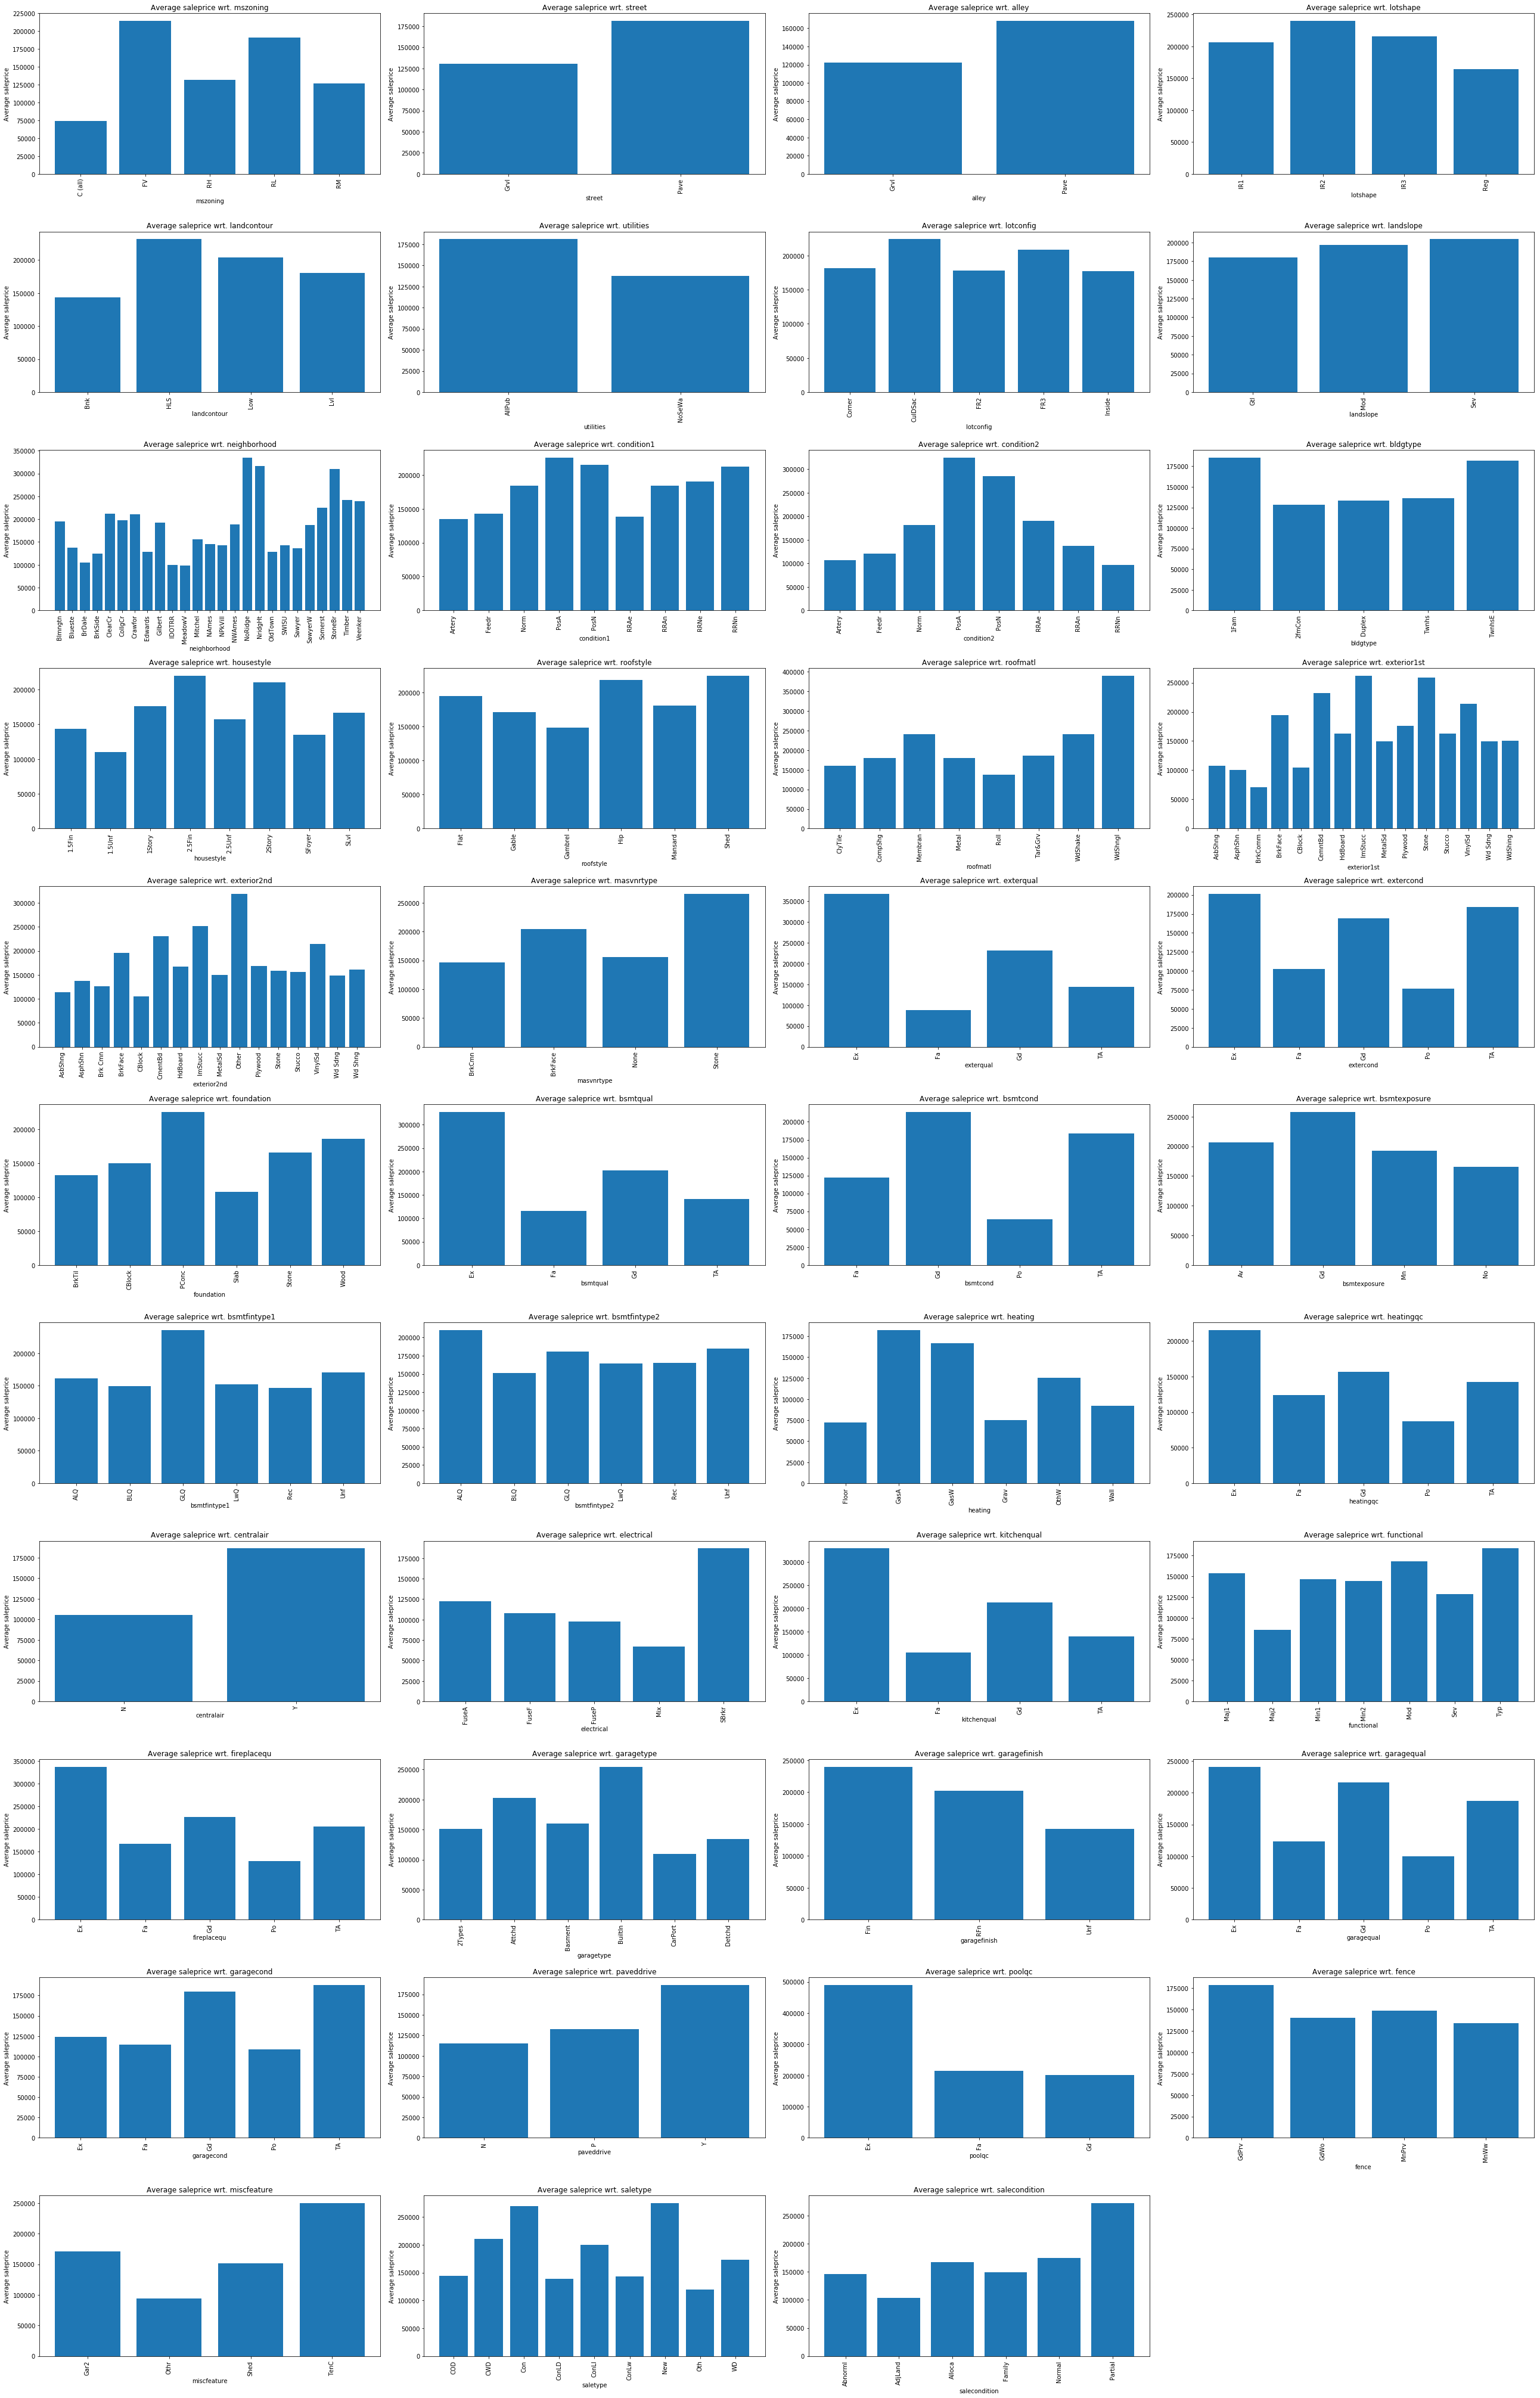

In [47]:
categorical_variables = list(house_prices.select_dtypes(['object']).columns)
plt.figure(figsize = (36, 56))
for i, category in zip(range(len(categorical_variables)),categorical_variables):
    plt.subplot(11,4,i+1)
    plt.bar(house_prices.groupby(category)["saleprice"].mean().index
            , house_prices.groupby(category)["saleprice"].mean())
    plt.title("Average saleprice wrt. {}".format(category))
    plt.ylabel("Average saleprice")
    plt.xlabel(category)
    plt.xticks(rotation='vertical')
plt.tight_layout()

From the plots above we can see that many of the variables have strong relationship with the target variable.also applying PCA is a best practice for coming up with the best representative features, lets add 1 variable with the strongest relationship with the target variable in to our model.Lets take 'centralair' variable as it seems more related as compared to the other variables with two values.  

In [72]:
house_prices['is_z_centralair'] = pd.get_dummies(house_prices.centralair, drop_first=True)

In [71]:
num_columns = list(corr_matrix.columns)
num_columns.append('is_z_centralair')
X = house_prices[num_columns]
Y = house_prices['saleprice']

 lets fit the regression model now;

In [74]:
import statsmodels.api as sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.049e+31
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        06:45:28   Log-Likelihood:                 31290.
No. Observations:                1460   AIC:                        -6.256e+04
Df Residuals:                    1451   BIC:                        -6.251e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.689e-10   1.97e-11      8.577      0.000     1.3e-10    2.08e-10
overallqual     -4.934e-11   3.88e-12    -12.718      0.000    -5.7e-11   -4.17e-11
totalbsmtsf     -1.332e-14   1.35e-14     -0.990      0.323   -3.97e-14    1.31e-14
firstflrsf       3.908e-14   1.55e-14      2.517      0.012    8.62e-15    6.95e-14
grlivarea        1.421e-14   9.02e-15      1.576      0.115   -3.48e-15    3.19e-14
garagecars      -2.228e-11   9.37e-12     -2.379      0.018   -4.07e-11   -3.91e-12
garagearea       1.323e-13   3.23e-14      4.098      0.000     6.9e-14    1.96e-13
saleprice           1.0000    8.1e-17   1.23e+16      0.000       1.000       1.000
is_z_centralair  1.046e-11   1.34e-11      0.780      0.436   -1.58e-11    3.68e-11
==============================================================================
Omnibus:                       41.685   Durbin-Watson:                   0.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.032
Skew:                           0.309   Prob(JB):                     6.80e-13
Kurtosis:                       3.734   Cond. No.                     1.34e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

the estimated parameters are the values of the 'coef' columns in the above table.